<a href="https://colab.research.google.com/github/Eternoxy/OpenBrakes/blob/main/OpenBrakesAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install gpxpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.6/111.6 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gpxpy: filename=gpxpy-1.5.0-py3-none-any.whl size=42881 sha256=ddb77367925810f86a2a1f917fa567ef970781b0fe91f86f6d86493efe3443a6
  Stored in directory: /root/.cache/pip/wheels/37/e1/72/25e1b018a67df6cb99583bef9b53b53e9ef59826ee514751aa
Successfully built gpxpy


In [3]:
import pandas as pd
import gpxpy
import matplotlib.pyplot as plt
import numpy as np

# Load brake data
brake_data = pd.read_csv('/content/2023-9-25-17-5-17.csv')

# Load and parse GPX data
with open('/content/activity_12103327262.gpx', 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)

# Convert GPX data to DataFrame
data = []
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            data.append([point.time, point.latitude, point.longitude, point.elevation])

gpx_data = pd.DataFrame(data, columns=['time', 'latitude', 'longitude', 'elevation'])


In [4]:
# Convert the Unix timestamp in brakedata dataframe to a datetime format
brake_data['Timestamp'] = pd.to_datetime(brake_data['Timestamp'], unit='s')

In [5]:
gpx_data.head()

,time,latitude,longitude,elevation
0,2023-09-25 15:05:14+00:00,47.259322,11.438028,592.799988
1,2023-09-25 15:05:18+00:00,47.259324,11.438031,591.799988
2,2023-09-25 15:05:19+00:00,47.259336,11.438057,591.799988
3,2023-09-25 15:05:20+00:00,47.259345,11.438086,592.000000
4,2023-09-25 15:05:21+00:00,47.259352,11.438120,591.799988


In [6]:
brake_data.head()

,Timestamp,Torque,Temperature,RPM
0,2023-09-25 15:05:18,0.26,19.34,0.0
1,2023-09-25 15:05:18,0.26,19.30,0.0
2,2023-09-25 15:05:19,0.26,19.50,0.0
3,2023-09-25 15:05:20,0.27,19.44,0.0
4,2023-09-25 15:05:21,0.26,19.31,0.0


In [7]:
# Set timezone info for both dataframes
brake_data['Timestamp'] = brake_data['Timestamp'].dt.tz_localize('UTC')
brake_data['Timestamp'] = brake_data['Timestamp'].dt.tz_convert('Europe/Berlin')
gpx_data['time'] = pd.to_datetime(gpx_data['time']).dt.tz_convert('Europe/Berlin')

In [8]:
brake_data.head()

,Timestamp,Torque,Temperature,RPM
0,2023-09-25 17:05:18+02:00,0.26,19.34,0.0
1,2023-09-25 17:05:18+02:00,0.26,19.30,0.0
2,2023-09-25 17:05:19+02:00,0.26,19.50,0.0
3,2023-09-25 17:05:20+02:00,0.27,19.44,0.0
4,2023-09-25 17:05:21+02:00,0.26,19.31,0.0


In [9]:
gpx_data.head()

,time,latitude,longitude,elevation
0,2023-09-25 17:05:14+02:00,47.259322,11.438028,592.799988
1,2023-09-25 17:05:18+02:00,47.259324,11.438031,591.799988
2,2023-09-25 17:05:19+02:00,47.259336,11.438057,591.799988
3,2023-09-25 17:05:20+02:00,47.259345,11.438086,592.000000
4,2023-09-25 17:05:21+02:00,47.259352,11.438120,591.799988


In [10]:
# Make sure both dataframes are sorted by their timestamps
brake_data = brake_data.sort_values(by='Timestamp')
gpx_data = gpx_data.sort_values(by='time')

# Set timestamps as index
brake_data.set_index('Timestamp', inplace=True)
gpx_data.set_index('time', inplace=True)

# Resample both datasets to 1-second frequency (you can adjust the frequency as needed)
brake_data_resampled = brake_data.resample('1S').mean()

# Interpolate the data to fill in gaps after resampling
brake_data_resampled.interpolate(method='pad', inplace=True)

# Combine the datasets
combined_data = pd.concat([brake_data_resampled, gpx_data], axis=1, join='inner')


In [11]:
combined_data.head()

,Torque,Temperature,RPM,latitude,longitude,elevation
2023-09-25 17:05:18+02:00,0.26,19.32,0.0,47.259324,11.438031,591.799988
2023-09-25 17:05:19+02:00,0.26,19.50,0.0,47.259336,11.438057,591.799988
2023-09-25 17:05:20+02:00,0.27,19.44,0.0,47.259345,11.438086,592.000000
2023-09-25 17:05:21+02:00,0.26,19.31,0.0,47.259352,11.438120,591.799988
2023-09-25 17:05:26+02:00,0.27,18.87,0.0,47.259411,11.438343,592.000000


In [12]:
import math

WHEEL_DIAMETER = 0.74  # example value in meters


# Compute the elapsed time in seconds
first_timestamp = combined_data.index[0]
combined_data['seconds_elapsed'] = (combined_data.index - first_timestamp).total_seconds()



# Calculate the radius of the wheel
radius = WHEEL_DIAMETER / 2

# Calculate the force using the given torque values
combined_data['Force'] = combined_data['Torque'] / radius

# Continue with the earlier calculations for speed and brake power

# Function to compute distance in meters between two GPS points using the Haversine formula
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371000  # Radius of Earth in meters
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)

    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2.0) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return R * c

# Calculate speeds in m/s
distances = [0]
speeds = [0]  # Initial speed is 0

for i in range(1, len(combined_data)):
    distance = haversine_distance(
        combined_data.iloc[i-1]['latitude'],
        combined_data.iloc[i-1]['longitude'],
        combined_data.iloc[i]['latitude'],
        combined_data.iloc[i]['longitude']
    )
    distances.append(distance)

    time_interval = (combined_data.index[i] - combined_data.index[i-1]).seconds
    speed = distance / time_interval if time_interval > 0 else 0
    speeds.append(speed)

combined_data['Speed_m/s'] = speeds

# Calculating Brake Power in terms of torque and RPM
combined_data['Brake_Power_Torque_W'] = 2 * math.pi * combined_data['Torque'] * combined_data['RPM'] / 60

# Calculating Brake Power in terms of Force and linear distance
combined_data['Brake_Power_Force_W'] = combined_data['Force'] * combined_data['Speed_m/s']

print(combined_data.head())

                           Torque  Temperature  RPM   latitude  longitude  \
2023-09-25 17:05:18+02:00    0.26        19.32  0.0  47.259324  11.438031   
2023-09-25 17:05:19+02:00    0.26        19.50  0.0  47.259336  11.438057   
2023-09-25 17:05:20+02:00    0.27        19.44  0.0  47.259345  11.438086   
2023-09-25 17:05:21+02:00    0.26        19.31  0.0  47.259352  11.438120   
2023-09-25 17:05:26+02:00    0.27        18.87  0.0  47.259411  11.438343   

                            elevation  seconds_elapsed     Force  Speed_m/s  \
2023-09-25 17:05:18+02:00  591.799988              0.0  0.702703   0.000000   
2023-09-25 17:05:19+02:00  591.799988              1.0  0.702703   2.350340   
2023-09-25 17:05:20+02:00  592.000000              2.0  0.729730   2.480257   
2023-09-25 17:05:21+02:00  591.799988              3.0  0.702703   2.663392   
2023-09-25 17:05:26+02:00  592.000000              8.0  0.729730   3.605912   

                           Brake_Power_Torque_W  Brake_Power_F

In [13]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 373 entries, 2023-09-25 17:05:18+02:00 to 2023-09-25 17:14:59+02:00
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Torque                373 non-null    float64
 1   Temperature           373 non-null    float64
 2   RPM                   373 non-null    float64
 3   latitude              373 non-null    float64
 4   longitude             373 non-null    float64
 5   elevation             373 non-null    float64
 6   seconds_elapsed       373 non-null    float64
 7   Force                 373 non-null    float64
 8   Speed_m/s             373 non-null    float64
 9   Brake_Power_Torque_W  373 non-null    float64
 10  Brake_Power_Force_W   373 non-null    float64
dtypes: float64(11)
memory usage: 35.0 KB


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import folium
import branca.colormap as cm

# Create a color map based on the brake power values
min_brake_power = combined_data['Brake_Power_Force_W'].min()
max_brake_power = combined_data['Brake_Power_Force_W'].max()
colormap = cm.LinearColormap(colors=['green', 'yellow', 'red'], vmin=min_brake_power, vmax=max_brake_power)

# Prepare the data for the polyline
locations = list(zip(combined_data['latitude'], combined_data['longitude']))
colors = combined_data['Brake_Power_Force_W'].apply(colormap).tolist()

# Create the map centered on the mean location
m = folium.Map(location=[combined_data['latitude'].mean(), combined_data['longitude'].mean()], zoom_start=13)

# Add the colored polyline
for i in range(1, len(locations)):
    folium.PolyLine([locations[i-1], locations[i]], color=colors[i], weight=4).add_to(m)

# Add the colormap to the map as a legend
colormap.caption = "Brake Power"
m.add_child(colormap)

# Save the map
m.save('/map.html')

In [27]:
# Extracting Statistics
stats_overview = combined_data[['Speed_m/s', 'Brake_Power_Force_W', 'elevation', 'Torque']].describe()
print(stats_overview)
duration = combined_data.index[-1] - combined_data.index[0]
print(duration)
elevation_change = stats_overview.at['max', 'elevation'] - stats_overview.at['min', 'elevation']
print(elevation_change)
total_distance = sum(distances)
print(total_distance)

        Speed_m/s  Brake_Power_Force_W   elevation      Torque
count  373.000000           373.000000  373.000000  373.000000
mean     4.806867            50.028442  597.834852    3.882507
std      2.519451            70.687492    3.641097    3.427969
min      0.000000             0.000000  589.799988    0.260000
25%      3.603477             9.438266  594.599976    1.380000
50%      4.437435            23.759615  598.599976    2.050000
75%      5.891046            66.858397  601.200012    6.255000
max     11.085500           559.275670  602.599976   19.790000
0 days 00:09:41
12.79998779296875
2932.502391324311


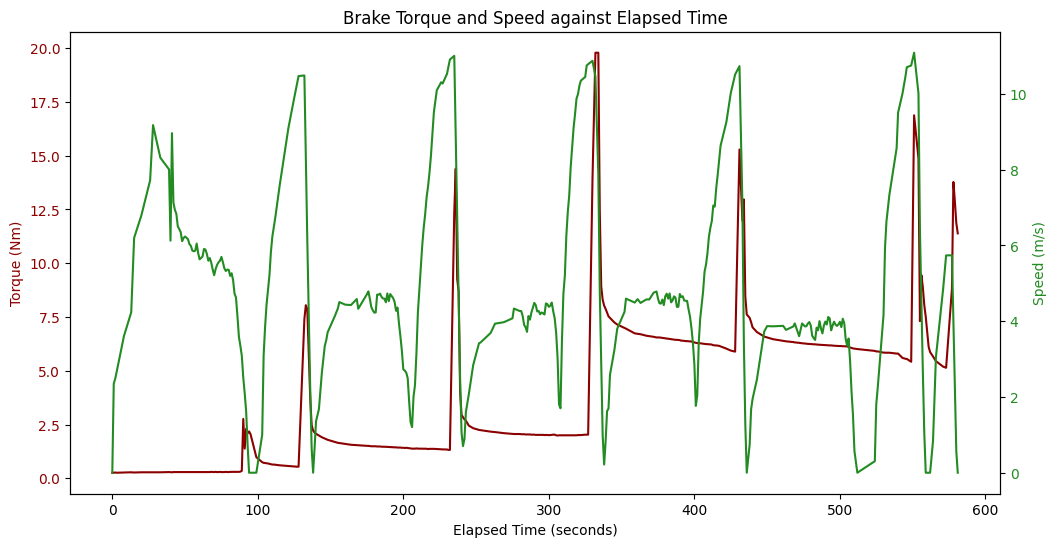

In [15]:
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('Elapsed Time (seconds)')
ax1.set_ylabel('Torque (Nm)', color='#8B0000')
ax1.plot(combined_data['seconds_elapsed'], combined_data['Torque'], color='#8B0000')
ax1.tick_params(axis='y', labelcolor='#8B0000')

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Speed (m/s)', color='#228B22')
ax2.plot(combined_data['seconds_elapsed'], combined_data['Speed_m/s'], color='#228B22')
ax2.tick_params(axis='y', labelcolor='#228B22')

plt.title("Brake Torque and Speed against Elapsed Time")
plt.savefig('torque_speed.png', dpi=600)
plt.show()


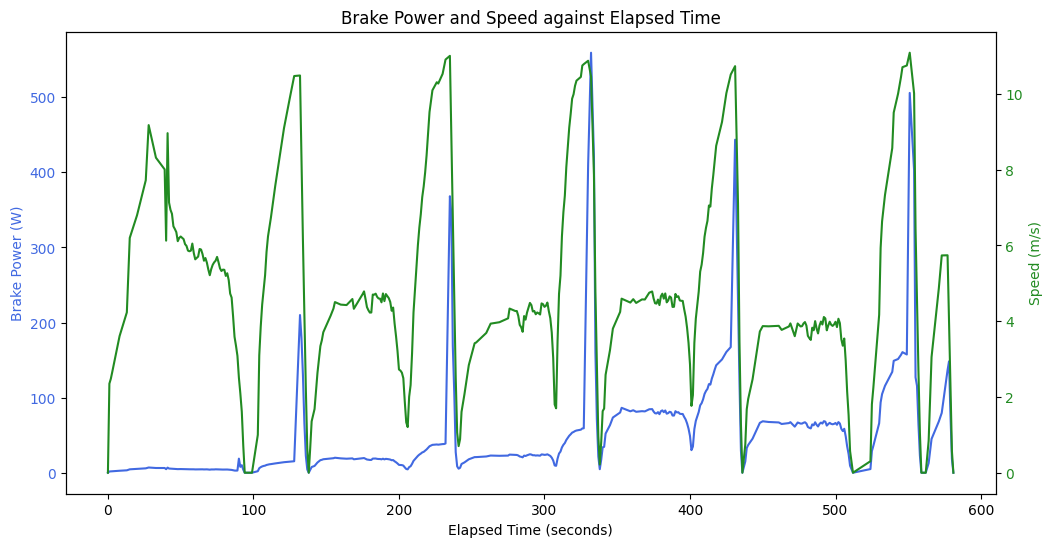

In [16]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Torque (Brake Power Force) with respect to Elapsed Time
color = 'tab:red'
ax1.set_xlabel('Elapsed Time (seconds)')
ax1.set_ylabel('Brake Power (W)', color='#4169E1')
ax1.plot(combined_data['seconds_elapsed'], combined_data['Brake_Power_Force_W'], color='#4169E1')
ax1.tick_params(axis='y', labelcolor='#4169E1')

# Plot Speed with respect to Elapsed Time on a twin axis
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Speed (m/s)', color='#228B22')
ax2.plot(combined_data['seconds_elapsed'], combined_data['Speed_m/s'], color='#228B22')
ax2.tick_params(axis='y', labelcolor='#228B22')

plt.title("Brake Power and Speed against Elapsed Time")
plt.savefig('power_speed.png', dpi=600)
plt.show()


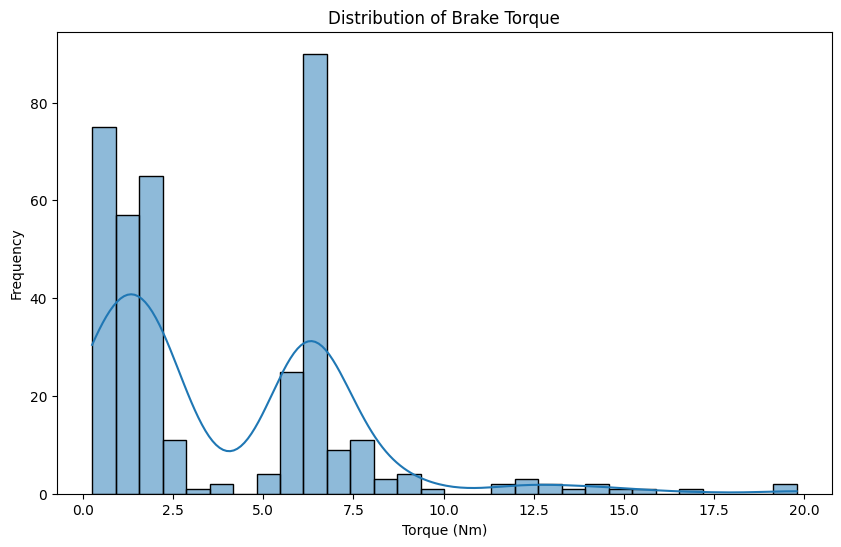

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(combined_data['Torque'], bins=30, kde=True)
plt.title("Distribution of Brake Torque")
plt.xlabel("Torque (Nm)")
plt.ylabel("Frequency")
plt.show()


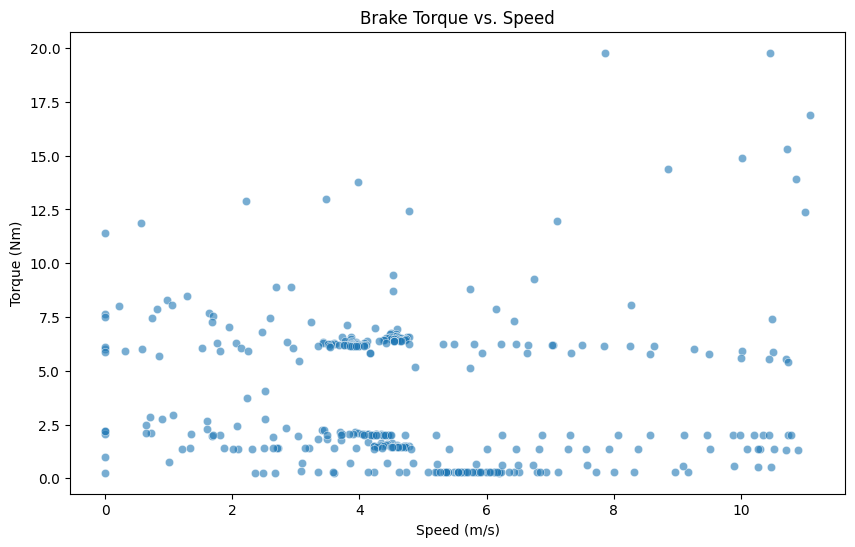

In [18]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=combined_data, x='Speed_m/s', y='Torque', alpha=0.6)
plt.title("Brake Torque vs. Speed")
plt.xlabel("Speed (m/s)")
plt.ylabel("Torque (Nm)")
plt.show()



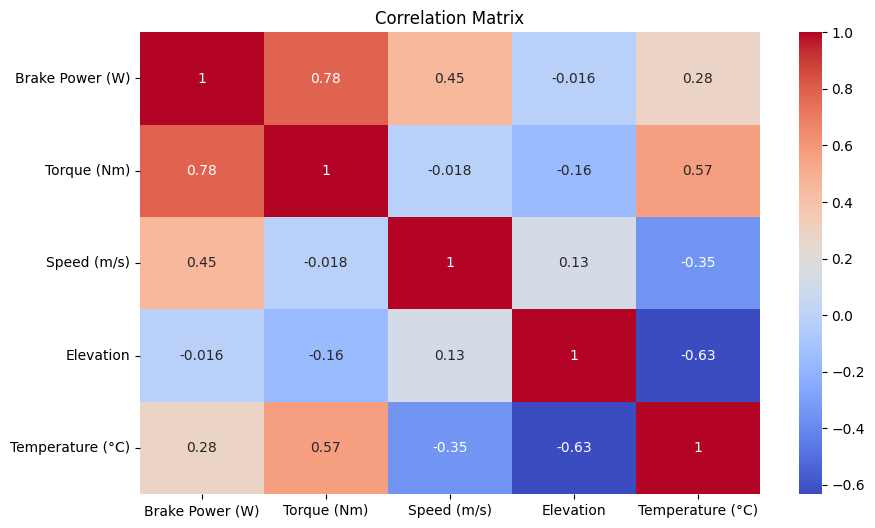

In [19]:
# Selecting the relevant columns
correlation_data = combined_data[['Brake_Power_Force_W', 'Torque', 'Speed_m/s', 'elevation', 'Temperature']]
correlation_matrix = correlation_data.corr()

correlation_data.columns = ['Brake Power (W)', 'Torque (Nm)', 'Speed (m/s)', 'Elevation', 'Temperature (°C)']

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", xticklabels=correlation_data.columns, yticklabels=correlation_data.columns)
plt.title("Correlation Matrix")
plt.savefig('correlation.png', dpi=600)
plt.show()


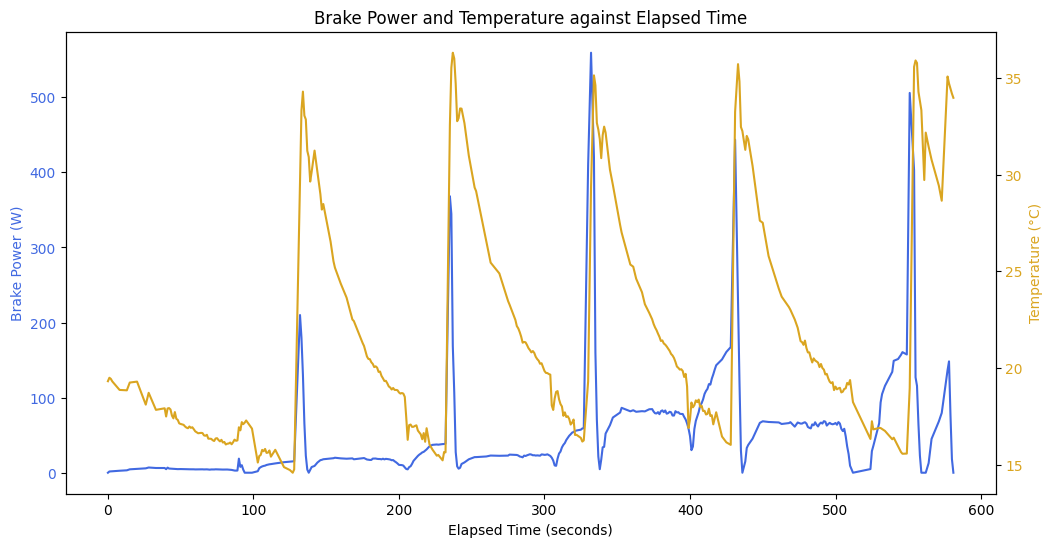

In [20]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Torque with respect to Elapsed Time
color = 'tab:red'
ax1.set_xlabel('Elapsed Time (seconds)')
ax1.set_ylabel('Brake Power (W)', color='#4169E1')
ax1.plot(combined_data['seconds_elapsed'], combined_data['Brake_Power_Force_W'], color='#4169E1')
ax1.tick_params(axis='y', labelcolor='#4169E1')

# Plot Temperature with respect to Elapsed Time on a twin axis
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Temperature (°C)', color='#DAA520')
ax2.plot(combined_data['seconds_elapsed'], combined_data['Temperature'], color='#DAA520')
ax2.tick_params(axis='y', labelcolor='#DAA520')

plt.title("Brake Power and Temperature against Elapsed Time")
plt.savefig('power_temp.png', dpi=600)
plt.show()


In [21]:
# Compute the gradient (rate of change) of the temperature
combined_data['Temp_Gradient'] = np.gradient(combined_data['Temperature'])
# Add a constant to the dataset for the regression intercept
X = sm.add_constant(combined_data['Brake_Power_Force_W'])

# The dependent variable is the temperature gradient
y = combined_data['Temperature']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            Temperature   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     32.06
Date:                Fri, 29 Sep 2023   Prob (F-statistic):           3.00e-08
Time:                        14:12:30   Log-Likelihood:                -1163.3
No. Observations:                 373   AIC:                             2331.
Df Residuals:                     371   BIC:                             2338.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  20.0941    

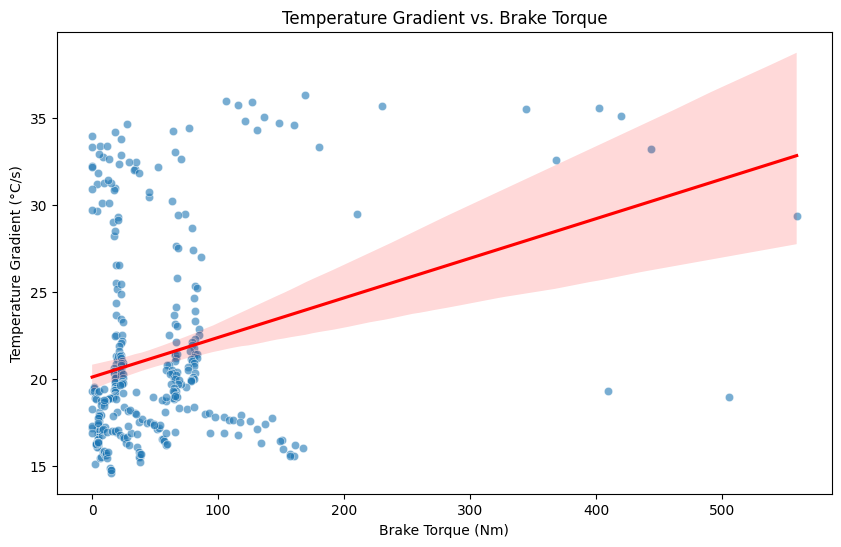

In [22]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=combined_data, x='Brake_Power_Force_W', y='Temperature', alpha=0.6)
sns.regplot(data=combined_data, x='Brake_Power_Force_W', y='Temperature', scatter=False, color='red')  # Regression line
plt.title("Temperature Gradient vs. Brake Torque")
plt.xlabel("Brake Torque (Nm)")
plt.ylabel("Temperature Gradient (°C/s)")
plt.show()